# Mismatch analysis tool

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
from IPython.core.interactiveshell import InteractiveShell

InteractiveShell.ast_node_interactivity = "all"

In [2]:
from pathlib import Path
import pandas as pd
import numpy as np
from shifting_baseline.utils.log import get_logger, adjust_log_level

# 获取项目模块的 logger
log = get_logger()

# 在 notebook 中动态调整日志等级
adjust_log_level(console_level="INFO", file_level="DEBUG")

In [3]:
from shifting_baseline.data import load_data
from hydra import compose, initialize

with initialize(config_path="../config", version_base=None):
    cfg = compose(config_name="config")

# 加载数据
combined, uncertainties, history = load_data(cfg)
combined.head()

INFO | 加载自然数据 [1000-1900]...
INFO | 从文件加载处理后的自然数据 ...
INFO | 加载历史数据 ...
INFO | 处理为对称等级 ...
INFO | 处理为标准化等级 ...
INFO | 通过随机采样处理为标准化等级，生成 100 个样本 ...


/Users/songshgeo/Documents/VSCode/shifting_baseline/shifting_baseline/data.py:218: RuntimeWarning: Mean of empty slice
  np.nanmean(data, axis=0),
/Users/songshgeo/Documents/VSCode/shifting_baseline/.venv/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


,mean,sd,hdi_3%,hdi_97%
year,,,,
1000,-0.159,0.374,-0.867,0.529
1001,-0.054,0.372,-0.772,0.619
1002,0.496,0.443,-0.299,1.353
1003,0.067,0.542,-0.954,1.101
1004,-0.708,0.523,-1.683,0.258


## 测试数据

这里主要是看一下同样的 pattern 是不是在测试阶段 1900-2010 不出现

In [4]:
from shifting_baseline.filters import classify
from shifting_baseline.calibration import MismatchReport
from shifting_baseline.data import load_validation_data

best_val_data = cfg.using_val_data
ds = cfg.ds.validation[best_val_data]
# 校验数据
_, validation_data = load_validation_data(
    data_path=ds.z_nc,
    resolution=cfg.resolution,
    csv_save_to=ds.csv,
    nc_save_to=ds.z_nc,
)

# 数轮数据
tree_ring = combined["mean"]
validation_mismatch_report = MismatchReport(
    pred=classify(validation_data),
    true=classify(tree_ring),
    value_series=tree_ring,
)
validation_mismatch_report

INFO | 从 /Users/songshgeo/Documents/VSCode/shifting_baseline/data/JAS_z_China_1900-2017.nc 加载验证数据 ...
INFO | 从文件加载处理后的 z-score 验证数据 ...
INFO | 从 /Users/songshgeo/Documents/VSCode/shifting_baseline/data/JAS_z_China.csv 加载区域降水 z-score 验证数据 ...
INFO | 有效样本数: 113


MismatchReport(n_samples=113)

INFO | 开始错误分析
INFO | 开始蒙特卡洛模拟 (n=1000)


MC模拟:   0%|          | 0/1000 [00:00<?, ?it/s]

INFO | 正差异约为 0.10
INFO | 负差异约为 0.17
INFO | 平均差异约为 0.13
INFO | 开始生成报告图表


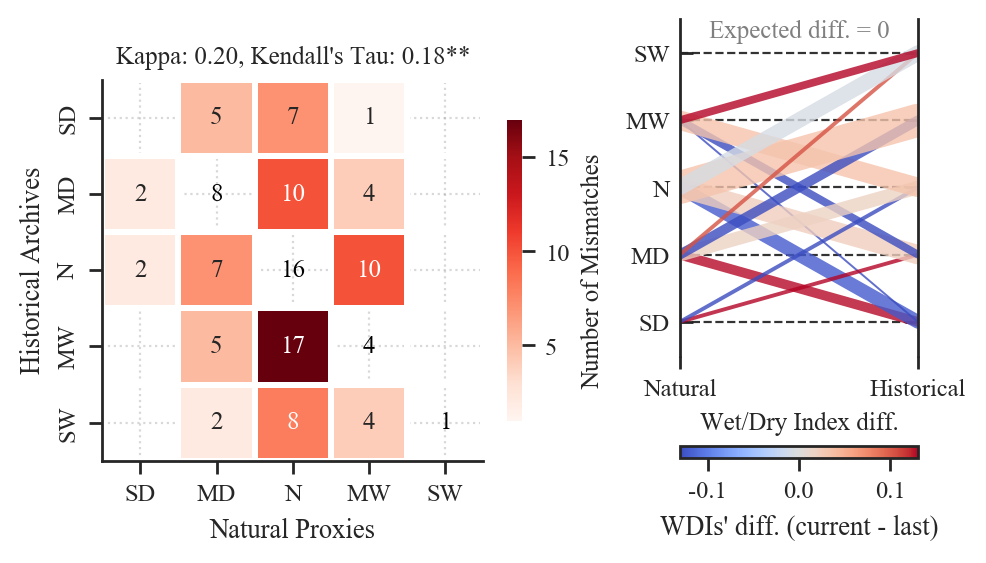

In [5]:
log.info("开始错误分析")
validation_mismatch_report.analyze_error_patterns()
log.info(f"正差异约为 {validation_mismatch_report.get_mean_diff('positive'):.2f}")
log.info(f"负差异约为 {validation_mismatch_report.get_mean_diff('negative'):.2f}")
log.info(f"平均差异约为 {validation_mismatch_report.get_mean_diff():.2f}")
log.info("开始生成报告图表")
validation_mismatch_report.generate_report_figure();

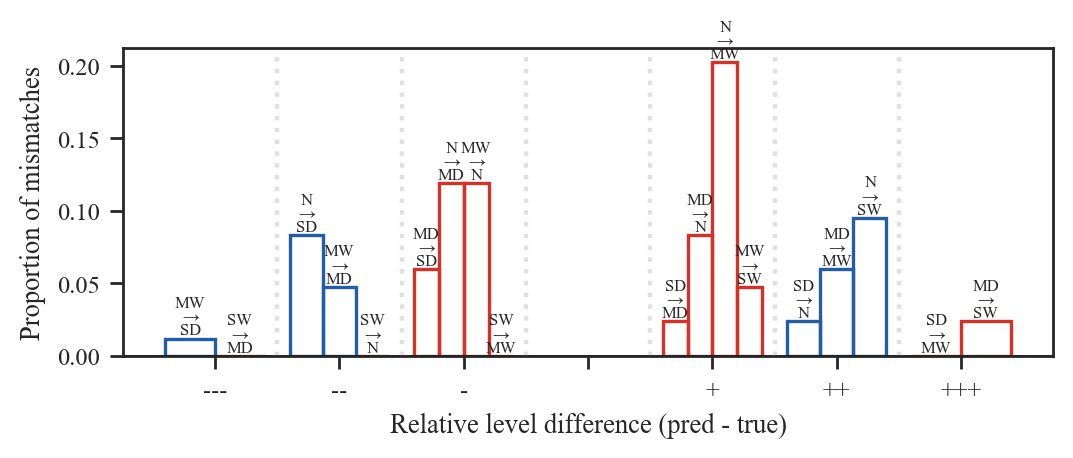

In [6]:
from matplotlib import pyplot as plt

fig, ax = plt.subplots(figsize=(6, 2))
ax = validation_mismatch_report.plot_mismatch_bar(show_pair_labels=True, ax=ax)

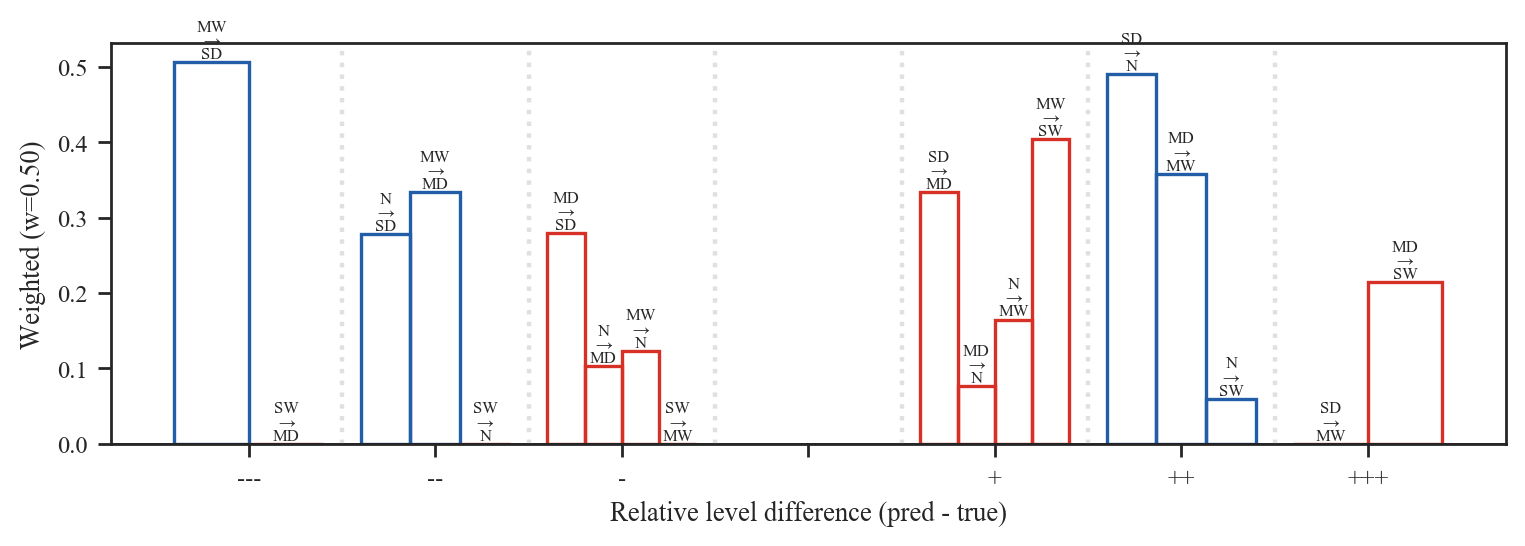

In [7]:
ax = validation_mismatch_report.plot_mismatch_bar(
    show_pair_labels=True, y_metric="weighted"
)

## 数轮+历史数据对比

In [8]:
history.setup()
pred, true = history.aggregate(
    how=cfg.agg_method,
    to_int=False,
    inplace=True,
).merge_with(
    combined["mean"],
    time_range="2-3",
    split=True,
)

mismatch_report = MismatchReport(
    pred=classify(pred, handle_na="skip"),
    true=classify(true, handle_na="skip"),
    value_series=true,
)
mismatch_report
mismatch_report.analyze_error_patterns()

INFO | 处理为对称等级 ...
INFO | 处理为标准化等级 ...
INFO | 通过随机采样处理为标准化等级，生成 100 个样本 ...
INFO | 有效样本数: 208


/Users/songshgeo/Documents/VSCode/shifting_baseline/shifting_baseline/data.py:218: RuntimeWarning: Mean of empty slice
  np.nanmean(data, axis=0),
/Users/songshgeo/Documents/VSCode/shifting_baseline/.venv/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


MismatchReport(n_samples=208)

INFO | 开始蒙特卡洛模拟 (n=1000)


MC模拟:   0%|          | 0/1000 [00:00<?, ?it/s]

true,-2,-1,0,1,2
pred,,,,,
-2,NaN,-0.144500,NaN,NaN,NaN
-1,-0.1995,NaN,0.028421,-0.025889,NaN
0,NaN,0.011957,NaN,0.001350,NaN
1,NaN,0.128200,0.025541,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN


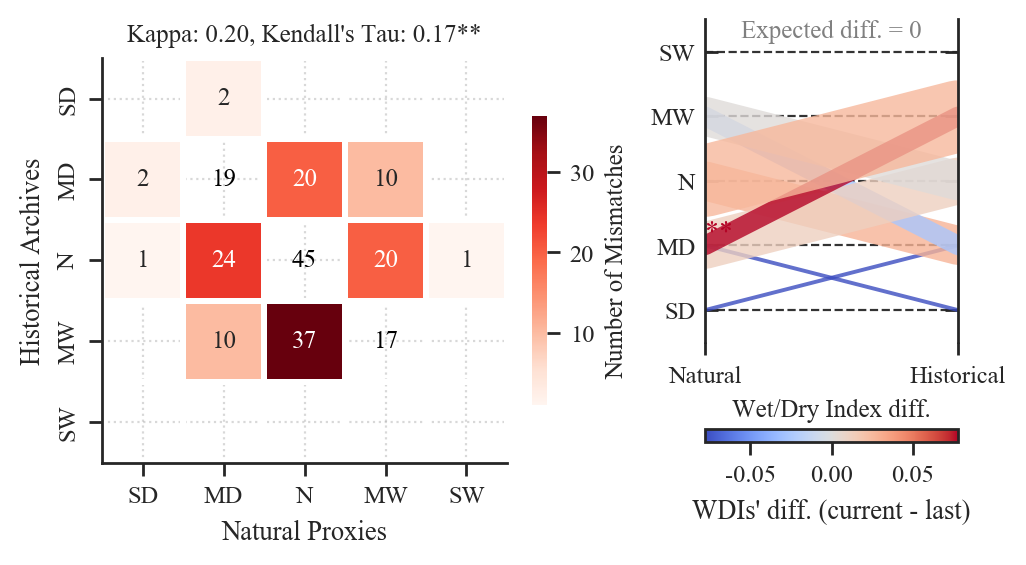

In [9]:
fig = mismatch_report.generate_report_figure(figsize=(5.2, 3))

Figure 1. a: confusion matrix, showing the number of matched (diagonal, white colour) and mismatched (off-diagonal, red colour) judgments of extreme events between natural and recorded levels. b: mismatched between natural and recorded levels. The colour represents the standardised difference between natural and recorded levels. The line width represents the number of mismatches. The line colour represents the standardised difference between this judgement and the previous judgement at the same level. The line transparency represents the significance of the standardised difference (p < 0.05).

In [10]:
mismatch_report.diff_matrix.abs().mean().mean()

0.08374643706922025

<Axes: xlabel='Relative level difference (pred - true)', ylabel='Diff value'>

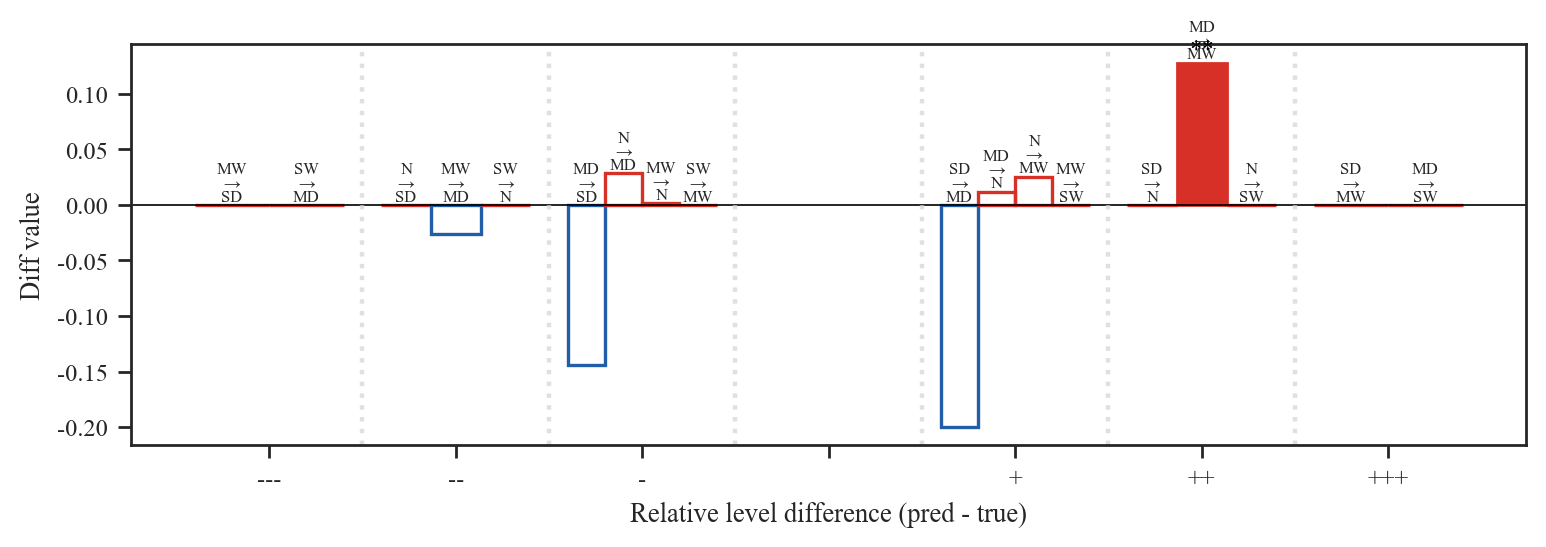

In [11]:
mismatch_report.plot_mismatch_bar(show_pair_labels=True, y_metric="diff")

### 测试不同的 shift

INFO | 正差异约为 0.04
INFO | 负差异约为 0.08
INFO | 平均差异约为 0.04
INFO | 开始蒙特卡洛模拟 (n=1000)


MC模拟:   0%|          | 0/1000 [00:00<?, ?it/s]

INFO | 正差异约为 0.03
INFO | 负差异约为 0.12
INFO | 平均差异约为 0.08
INFO | 开始蒙特卡洛模拟 (n=1000)


MC模拟:   0%|          | 0/1000 [00:00<?, ?it/s]

INFO | 正差异约为 0.07
INFO | 负差异约为 0.20
INFO | 平均差异约为 0.17
INFO | 开始蒙特卡洛模拟 (n=1000)


MC模拟:   0%|          | 0/1000 [00:00<?, ?it/s]

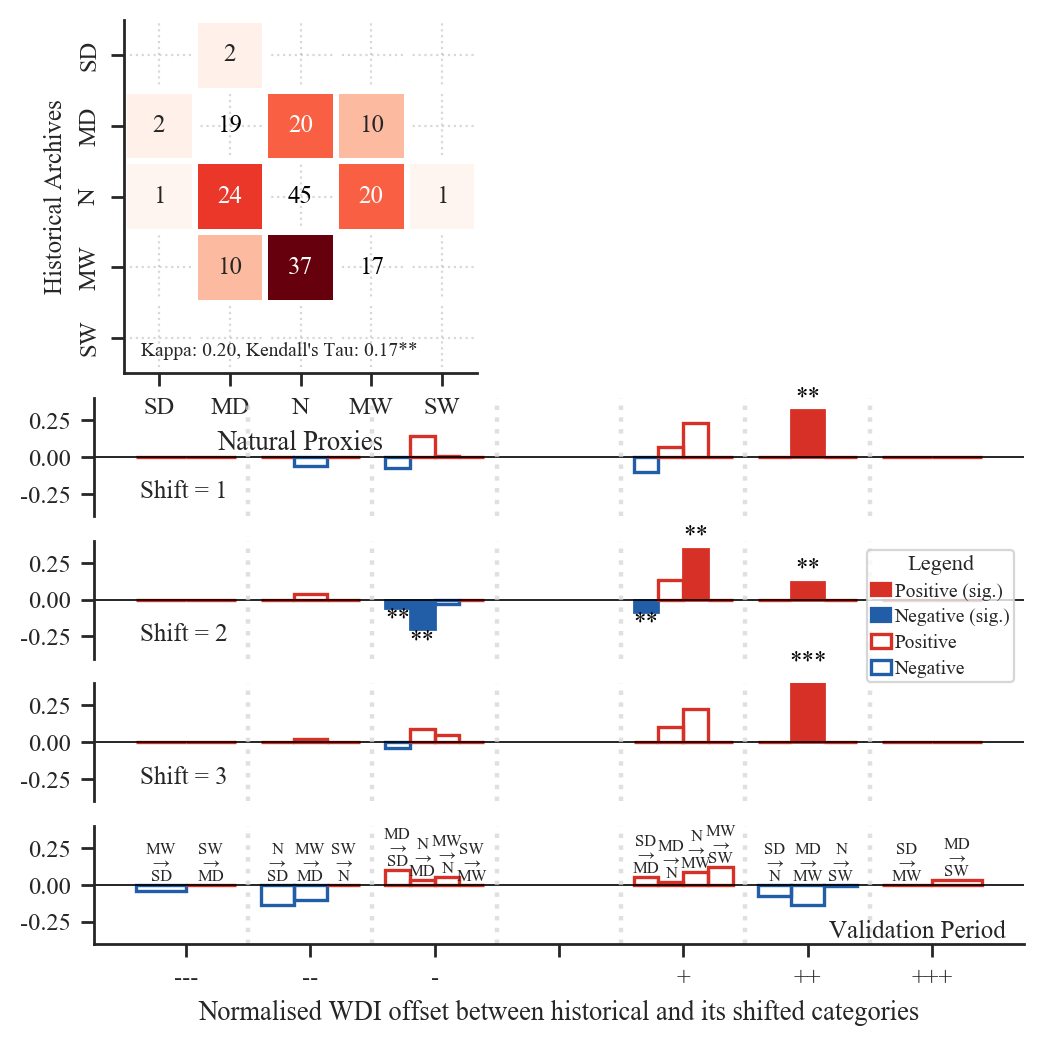

In [17]:
from matplotlib import pyplot as plt

y_metric = "norm_contribution"  # 选择 y 轴的 metric
if y_metric == "diff":
    ylim = (-0.15, 0.15)
elif y_metric == "contribution":
    ylim = (-0.02, 0.02)
elif y_metric == "proportion":
    ylim = (0, 0.3)
elif y_metric == "norm_contribution":
    ylim = (-0.4, 0.4)

fig = plt.figure(figsize=(6, 6), constrained_layout=False)
gs = fig.add_gridspec(
    5,
    2,
    hspace=0.15,
    wspace=0.25,
    width_ratios=[1, 1],
    height_ratios=[3, 1, 1, 1, 1],
)

# 绘制 confusion matrix
ax = fig.add_subplot(gs[0, 0])
mismatch_report.plot_confusion_matrix(ax=ax, cbar=False)
title = ax.get_title()
ax.set_title("")
ax.text(0.05, 0.05, title, transform=ax.transAxes, fontsize=7)

bar_axs = []
# 绘制 3 个 shift 的图
for shift in range(1, 4):
    show_legend = shift == 2
    ax = fig.add_subplot(gs[shift, :])
    log.info(f"正差异约为 {mismatch_report.get_mean_diff('positive'):.2f}")
    log.info(f"负差异约为 {mismatch_report.get_mean_diff('negative'):.2f}")
    log.info(f"平均差异约为 {mismatch_report.get_mean_diff():.2f}")
    mismatch_report.analyze_error_patterns(shift=shift)
    mismatch_report.plot_mismatch_bar(
        ax=ax,
        show_legend=show_legend,
        legend_loc="upper right",
        y_metric=y_metric,
        ylim=ylim,
    )
    bar_axs.append(ax)
    ax.set_facecolor("none")
    ax.set_xlabel("")
    ax.set_xticks([])
    ax.grid(False)
    ax.text(0.05, 0.15, f"Shift = {shift}", transform=ax.transAxes, fontsize=9)

# 绘制 validation 的图
val_ax = fig.add_subplot(gs[-1, :])
validation_mismatch_report.plot_mismatch_bar(
    ax=val_ax,
    show_pair_labels=True,
    y_metric=y_metric,
    ylim=ylim,
)
val_ax.set_facecolor("none")

for ax in [*bar_axs, val_ax]:
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines["bottom"].set_visible(False)
    ax.set_ylabel("")


val_ax.spines["bottom"].set_visible(True)
val_ax.text(
    0.98, 0.05, "Validation Period", ha="right", transform=val_ax.transAxes, fontsize=9
)
val_ax.set_xlabel("Normalised WDI offset between historical and its shifted categories")
# fig.savefig(cfg.ds.fig3)
plt.show();

### 保存结果

In [ ]:
import json
import numpy as np

# 读取数据（如果文件损坏就重新创建）
try:
    with open(cfg.ds.results, "r") as f:
        data = json.load(f)
except FileNotFoundError:
    data = {}

# 添加统计数据
results = mismatch_report.get_statistics_summary()
results["mean_diff"] = float(mismatch_report.diff_matrix.abs().mean().mean())
results["kendall_tau_validation"] = validation_mismatch_report.kendall_tau

# 转换 NumPy 类型并保留2位小数
for key, value in results.items():
    if isinstance(value, (np.floating, float)):
        results[key] = round(float(value), 2)
    elif isinstance(value, np.integer):
        results[key] = int(value)

data["results2"] = results


# 保存
with open(cfg.ds.results, "w") as f:
    json.dump(data, f, indent=2, ensure_ascii=False)
results

{'kappa': 0.2,
 'kendall_tau': 0.17,
 'tau_p_value': 0.0,
 'accuracy': 0.39,
 'n_samples': 208,
 'n_raw_samples': 432,
 'n_mismatches': 127,
 'mean_diff': 0.04}